<a href="https://colab.research.google.com/github/siva8696/Logistic-Regression-on-Cancer-Diagnosis/blob/master/Logistic_Regression_on_Cancer_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Personalized cancer diagnosis

**Description :**

Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/

Data: Memorial Sloan Kettering Cancer Center (MSKCC)

Download training_variants.zip and training_text.zip from Kaggle.

Context:
Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462

Problem statement :
Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

**Real-world/Business objectives and constraints.**

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

**ML Problem formulation :**

**Data Overview**

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

**Objective and Constraints :**

Objective: Predict the probability of each data-point belonging to each of the nine classes.

Constraints:

* Interpretability * Class probabilities are needed. * Penalize the errors in class probabilites => Metric is Log-loss. * No Latency constraints.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


**Reading Data**

**Reading Training Variants and Text data :**

In [78]:
import os
cwd = os.getcwd()
#print(cwd)
files = os.listdir(cwd)
#print(files)
data_var= pd.read_csv("sample_data/Case_Study1/training_variants")
#data_text=pd.read_csv("Case_Study1/training_text")
print("The Shape of the varaiants data is :",data_var.shape)
print("The total number of data points in variants data is",data_var.shape[0])
print("The total number of features in variants data is",data_var.shape[1])
print("The features are :",data_var.columns.values)
print("*"*50)
print(data_var.head())

The Shape of the varaiants data is : (3321, 4)
The total number of data points in variants data is 3321
The total number of features in variants data is 4
The features are : ['ID' 'Gene' 'Variation' 'Class']
**************************************************
   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4


In [79]:
data_text=pd.read_csv("sample_data/Case_Study1/training_text" , sep="\|\|", names=["ID","Text"], skiprows=1)
print("The Shape of the test data is :",data_text.shape)
print("The total number of data points in text data is",data_text.shape[0])
print("The total number of features in text data is",data_text.shape[1])
print("The features are :",data_text.columns.values)
print("*"*50)
print(data_text.head())

The Shape of the test data is : (3321, 2)
The total number of data points in text data is 3321
The total number of features in text data is 2
The features are : ['ID' 'Text']
**************************************************
   ID                                               Text
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...


**Preprocessing on  Text :**

In [80]:
import nltk
stop_words1 = nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:
print(stop_words)

{'for', 'will', 'yours', 'her', 'had', 'wouldn', 'too', 'but', 'it', 'up', 'in', 'whom', 'each', 'our', 'couldn', 'herself', 'most', 'hadn', 'shan', 'other', 'same', 'there', "wouldn't", 'below', 'any', 'is', 'mustn', 'they', 'just', 'was', "hadn't", 'your', 'ours', 't', 'between', 'them', 'myself', 'been', 'be', 'haven', 'own', "won't", 'his', 'o', 'after', 'who', 'few', 'again', "mightn't", 'i', 'won', 'doing', 'theirs', 'off', "you've", 'as', 'before', 'these', 'on', 'while', 'nor', 'll', 'ain', 'him', 'have', 'down', "you'd", 'do', "don't", 'isn', "aren't", "shan't", 'weren', 'doesn', 'how', "isn't", 'now', 'during', "didn't", "needn't", 'hers', 'by', 'above', 'wasn', 'at', 'such', 'very', 'some', "doesn't", 'mightn', 'only', 'the', 'to', 'a', 'out', "you're", 'me', 'more', 'an', 'when', 'can', 'he', 'does', 'himself', 'yourself', 'under', 'of', 'didn', 'you', "shouldn't", 'once', 'ma', "haven't", 'did', 'm', 'all', 'not', 'over', 'no', 'hasn', 'yourselves', "it's", 'why', 'about',

In [0]:
def nlp_preprocessing(text,index, column):
  if type(text) is not int:
    #Intiallizing the empty string
    string = ""
    #Removing the specail character and replace it with space
    text = re.sub('[^a-zA-Z0-9\n]',' ',text)
    #Removing the multiple spaces and replace it with single space
    text = re.sub('\s+',' ',text)
    #Converting the text into lower_case
    text = text.lower()
    #Removing the stop words from text and saving back into String
    
    for word in text.split():
      if not word in stop_words:
        string += word + " "
    data_text[column][index]=string
        

In [83]:
#Checking the starting time
start_time = time.clock()
#Using iterrows we are iterating the data frame with index 
for index, row in data_text.iterrows():
  if type(row['Text']) is str:
    nlp_preprocessing(row['Text'],index,'Text')
  else:
    print("There is no string at Index:", index)
print("Time taking to process the text data is :",time.clock()-start_time,"Seconds")

There is no string at Index: 1109
There is no string at Index: 1277
There is no string at Index: 1407
There is no string at Index: 1639
There is no string at Index: 2755
Time taking to process the text data is : 28.183251000000382 Seconds


In [84]:
#Merging the both Gene variations and Text data using ID
final_data = pd.merge(data_var,data_text, on = 'ID', how='left')
print(final_data.head())

   ID    Gene  ... Class                                               Text
0   0  FAM58A  ...     1  cyclin dependent kinases cdks regulate variety...
1   1     CBL  ...     2  abstract background non small cell lung cancer...
2   2     CBL  ...     2  abstract background non small cell lung cancer...
3   3     CBL  ...     3  recent evidence demonstrated acquired uniparen...
4   4     CBL  ...     4  oncogenic mutations monomeric casitas b lineag...

[5 rows x 5 columns]


In [85]:
final_data[final_data.isnull().values.any(axis=1)]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [0]:
final_data.loc[final_data['Text'].isnull(), 'Text'] = final_data['Gene']+' '+final_data['Variation']

<h3>Splitting the data into Train and CV and Test :

In [0]:
y_value = final_data['Class'].values
#Dividing the data into Train and Test and CV and Stratify make the class label in same distribution
X_train, X_test, y_train, y_test = train_test_split(final_data, y_value, stratify=y_value, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train ,test_size=0.2, random_state=42)

In [88]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)
print("Number of data points in cv data :",X_cv.shape)

Number of data points in train data : (2124, 5)
Number of data points in test data : (665, 5)
Number of data points in cv data : (532, 5)


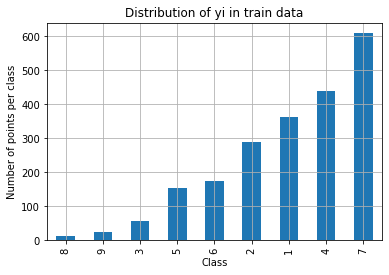

**************************************************


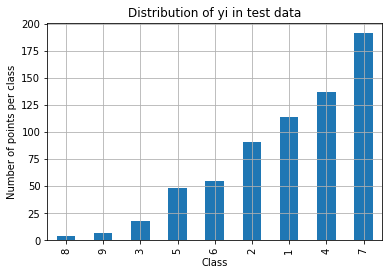

**************************************************


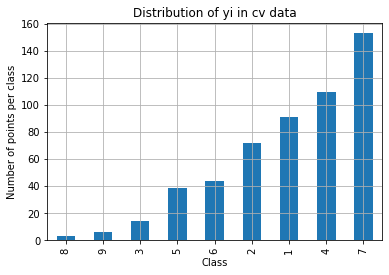

In [89]:
train_class_distribution=X_train['Class'].value_counts().sort_values()
#Plotting the distribution of yi in train data
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of points per class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()


print('*'*50)

test_class_distribution=X_test['Class'].value_counts().sort_values()
#Plotting the distribution of yi in test data
my_colors='rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of points per class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

print('*'*50)

cv_class_distribution=X_cv['Class'].value_counts().sort_values()
#Plotting the distribution of yi in test data
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of points per class')
plt.title('Distribution of yi in cv data')
plt.grid()
plt.show()


**Confusion Matrix, Precision, Re-call :**

In [0]:
def plot_confusion_matrix(y_test, y_pred):
  #Confusion matrix
  A = confusion_matrix(y_test,y_pred)
  #Precision matrix
  B = (((A.T)/(A.sum(axis=1))).T)
  #Recall matrix
  C = (A/A.sum(axis=0))

  labels = [1,2,3,4,5,6,7,8,9]
  #Plot the consuion matrix
  print("-"*20,"Confusion matrix","-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(A,annot=True,cmap="YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
  plt.xlabel("predicted Class")
  plt.ylabel("Actual Class")
  plt.show()

  #Plot the precision matrix
  print("-"*20,"Precision matrix (Column Sum = 1)","-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(C,annot=True,cmap="YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
  plt.xlabel("predicted Class")
  plt.ylabel("Actual Class")
  plt.show()

  #Plot the recall matrix
  print("-"*20,"Recall matrix (Row Sum = 1)","-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(B,annot=True,cmap="YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
  plt.xlabel("predicted Class")
  plt.ylabel("Actual Class")
  plt.show()

**Univariate analysis in Gene feature:**

In [91]:
unique_gene = X_train['Gene'].value_counts()
print("Number of unique Gene features are:",unique_gene[0])
print(unique_gene.head(10))

Number of unique Gene features are: 154
BRCA1     154
TP53      104
EGFR       89
PTEN       88
BRCA2      83
KIT        63
BRAF       60
ALK        43
ERBB2      41
PDGFRA     41
Name: Gene, dtype: int64


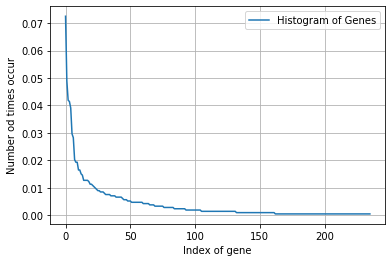

In [92]:
#print(unique_gene.values)
#print(sum(unique_gene.values))
s = sum(unique_gene.values)
h = unique_gene.values/s
plt.plot(h,label="Histogram of Genes")
plt.xlabel("Index of gene")
plt.ylabel("Number od times occur")
plt.legend()
plt.grid()
plt.show()

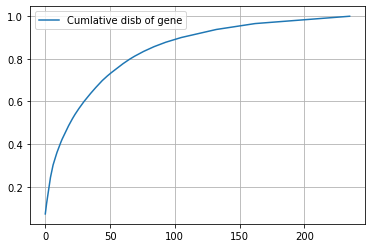

In [93]:
t = np.cumsum(h)
plt.plot(t,label="Cumlative disb of gene")
plt.legend()
plt.grid()
plt.show()

In [94]:
#Featurization for Gene feature using Tfidf Vectorizer
gene_vectorizer = TfidfVectorizer(stop_words='english')
train_gene_feature_tfidf = gene_vectorizer.fit_transform(X_train['Gene'])
cv_gene_feature_tfidf = gene_vectorizer.transform(X_cv['Gene'])
test_gene_feature_tfidf = gene_vectorizer.transform(X_test['Gene'])
print(train_gene_feature_tfidf.shape)
print(cv_gene_feature_tfidf.shape)
print(test_gene_feature_tfidf.shape)

(2124, 236)
(532, 236)
(665, 236)


In [0]:
#alpha = [10 ** x for x in range(-4,4)]
#a = []
#for i in alpha:
#  a.append(i)
#print(a)


For the C value  1e-05 the logg loss is : 1.4919499652925878
For the C value  0.0001 the logg loss is : 1.4864864467720382
For the C value  0.001 the logg loss is : 1.4637388159323976
For the C value  0.01 the logg loss is : 1.3545342286936608
For the C value  0.1 the logg loss is : 1.2925600079333792
For the C value  1 the logg loss is : 1.1899610564771046
For the C value  10 the logg loss is : 1.168477223443221
For the C value  100 the logg loss is : 1.190669597240119
For the C value  1000 the logg loss is : 1.2186525362488556
For the C value  10000 the logg loss is : 1.2411677304535413


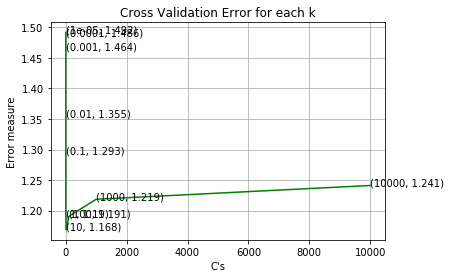

For values of C alpha =  10 The train log loss is: 0.9895439996043248
For values of C alpha =  10 The cross validation log loss is: 1.168477223443221
For values of C alpha =  10 The test log loss is: 1.2466627627285916


In [95]:
alpha = [10 ** x for x in range(-5,5)]
cv_log_error = []
for i in alpha:
  clf=LogisticRegression(class_weight='balanced',C=i,penalty='l2',random_state=42)
  clf.fit(train_gene_feature_tfidf,y_train)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_gene_feature_tfidf,y_train)
  predicted_y=sig_clf.predict_proba(cv_gene_feature_tfidf)
  cv_log_error.append(log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))
  print("For the C value ",i,"the logg loss is :",log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))


fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each k")
plt.xlabel("C's")
plt.ylabel("Error measure")
plt.show()


best_alpha_gene = np.argmin(cv_log_error)
clf = LogisticRegression(class_weight='balanced',C=alpha[best_alpha_gene],penalty='l2',random_state=42)
clf.fit(train_gene_feature_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_tfidf, y_train)

predict_y_gene = sig_clf.predict_proba(train_gene_feature_tfidf)
print('For values of C alpha = ', alpha[best_alpha_gene], "The train log loss is:",log_loss(y_train, predict_y_gene, labels=clf.classes_, eps=1e-15))
predict_y1_gene = sig_clf.predict_proba(cv_gene_feature_tfidf)
print('For values of C alpha = ', alpha[best_alpha_gene], "The cross validation log loss is:",log_loss(y_cv, predict_y1_gene, labels=clf.classes_, eps=1e-15))
predict_y2_gene = sig_clf.predict_proba(test_gene_feature_tfidf)
print('For values of C alpha = ', alpha[best_alpha_gene], "The test log loss is:",log_loss(y_test, predict_y2_gene, labels=clf.classes_, eps=1e-15))


In [96]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_gene.shape[0], " genes in train dataset?")

test_coverage=X_test[X_test['Gene'].isin(list(set(X_train['Gene'])))].shape[0]
cv_coverage=X_cv[X_cv['Gene'].isin(list(set(X_train['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',X_cv.shape[0],":" ,(cv_coverage/X_cv.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  236  genes in train dataset?
Ans
1. In test data 642 out of 665 : 96.54135338345866
2. In cross validation data 523 out of  532 : 98.30827067669173


As per the above analysis the Gene feature will be helpful for us to creating the model. Along with that we can see almost more than 96 percentage of test gene features are available in train gene.

**Univariate analysis on Variant feature :**

In [97]:
unique_var = X_train['Variation'].value_counts()
print("Number of unique Gene features are:",unique_var[0])
print(unique_var.head(10))

Number of unique Gene features are: 66
Truncating Mutations    66
Amplification           47
Deletion                42
Fusions                 23
Overexpression           4
T58I                     3
C618R                    2
G67R                     2
E542K                    2
Q22K                     2
Name: Variation, dtype: int64


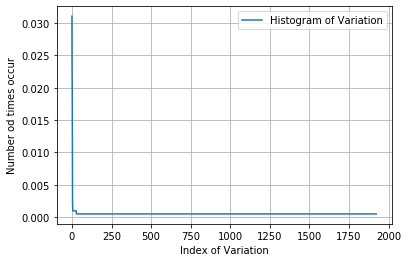

In [98]:
#print(unique_gene.values)
#print(sum(unique_gene.values))
s = sum(unique_var.values)
h = unique_var.values/s
plt.plot(h,label="Histogram of Variation")
plt.xlabel("Index of Variation")
plt.ylabel("Number od times occur")
plt.legend()
plt.grid()
plt.show()

In [99]:
#Tfidf Vectorizer for Variation feature
tfidf = TfidfVectorizer(stop_words="english",ngram_range=(1,1))
train_var_feature_tfidf = tfidf.fit_transform(X_train['Variation'])
cv_var_feature_tfidf = tfidf.transform(X_cv['Variation'])
test_var_feature_tfidf = tfidf.transform(X_test['Variation'])
print(train_var_feature_tfidf.shape)
print(cv_var_feature_tfidf.shape)
print(test_var_feature_tfidf.shape)

(2124, 1950)
(532, 1950)
(665, 1950)


For the C value  1e-05 the logg loss is : 1.7081289458002027
For the C value  0.0001 the logg loss is : 1.7074951671919785
For the C value  0.001 the logg loss is : 1.70250856589895
For the C value  0.01 the logg loss is : 1.6918140000127806
For the C value  0.1 the logg loss is : 1.6977563391404005
For the C value  1 the logg loss is : 1.6947005076836485
For the C value  10 the logg loss is : 1.6914554387414513
For the C value  100 the logg loss is : 1.6957293595001852
For the C value  1000 the logg loss is : 1.6998526556958347
For the C value  10000 the logg loss is : 1.7025494147195854


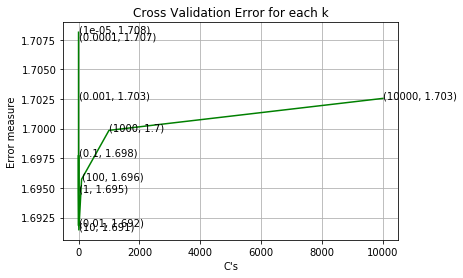

For values of C alpha =  10 The train log loss is: 0.7894118109840166
For values of C alpha =  10 The cross validation log loss is: 1.6914554387414513
For values of C alpha =  10 The test log loss is: 1.7180460938833293


In [100]:
alpha = [10 ** x for x in range(-5,5)]
cv_log_error = []
for i in alpha:
  clf=LogisticRegression(class_weight='balanced',C=i,penalty='l2',random_state=42)
  clf.fit(train_var_feature_tfidf,y_train)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_var_feature_tfidf,y_train)
  predicted_y=sig_clf.predict_proba(cv_var_feature_tfidf)
  cv_log_error.append(log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))
  print("For the C value ",i,"the logg loss is :",log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))


fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each k")
plt.xlabel("C's")
plt.ylabel("Error measure")
plt.show()


best_alpha_var = np.argmin(cv_log_error)
clf = LogisticRegression(class_weight='balanced',C=alpha[best_alpha_var],penalty='l2',random_state=42)
clf.fit(train_var_feature_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_var_feature_tfidf, y_train)

predict_y_var = sig_clf.predict_proba(train_var_feature_tfidf)
print('For values of C alpha = ', alpha[best_alpha_var], "The train log loss is:",log_loss(y_train, predict_y_var, labels=clf.classes_, eps=1e-15))
predict_y1_var = sig_clf.predict_proba(cv_var_feature_tfidf)
print('For values of C alpha = ', alpha[best_alpha_var], "The cross validation log loss is:",log_loss(y_cv, predict_y1_var, labels=clf.classes_, eps=1e-15))
predict_y2_var = sig_clf.predict_proba(test_var_feature_tfidf)
print('For values of C alpha = ', alpha[best_alpha_var], "The test log loss is:",log_loss(y_test, predict_y2_var, labels=clf.classes_, eps=1e-15))


In [101]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_var.shape[0], " variation in train dataset?")

test_coverage=X_test[X_test['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
cv_coverage=X_cv[X_cv['Variation'].isin(list(set(X_train['Variation'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',X_cv.shape[0],":" ,(cv_coverage/X_cv.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  1923  variation in train dataset?
Ans
1. In test data 67 out of 665 : 10.075187969924812
2. In cross validation data 53 out of  532 : 9.962406015037594


As per the above analysis the Variation feature will be not helpful for us to creating the model. Along with that we can see almost around 10 percentage of test Variation features are available in train Variation.

**Univariate analysis on Text feature :**

In [102]:
#Tfidf Vectorizer for Text feature
tfidf = TfidfVectorizer(stop_words="english",min_df=10,max_features=15000)
train_text_feature_tfidf = tfidf.fit_transform(X_train['Text'])
cv_text_feature_tfidf = tfidf.transform(X_cv['Text'])
test_text_feature_tfidf = tfidf.transform(X_test['Text'])
print(train_text_feature_tfidf.shape)
print(cv_text_feature_tfidf.shape)
print(test_text_feature_tfidf.shape)

(2124, 15000)
(532, 15000)
(665, 15000)


In [0]:

#print(tfidf.get_feature_names())
#print(np.argsort((tfidf.idf_)[::-1]))

In [0]:
#lectures = ["this is some food", "this is some drink"]
#vectorizer = TfidfVectorizer()
#X = vectorizer.fit_transform(lectures)
#indices = np.argsort(tfidf.idf_)[::-1]
#features = tfidf.get_feature_names()
#top_n = 10
#top_features = [features[i] for i in indices[:top_n]]
#print(top_features)

In [105]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
train_text_feature_tfidf = sc.fit_transform(train_text_feature_tfidf)
cv_text_feature_tfidf = sc.transform(cv_text_feature_tfidf)
test_text_feature_tfidf = sc.transform(test_text_feature_tfidf)
print(train_text_feature_tfidf.shape)
print(cv_text_feature_tfidf.shape)
print(test_text_feature_tfidf.shape)

(2124, 15000)
(532, 15000)
(665, 15000)


For the C value  1e-05 the logg loss is : 1.447520937778413
For the C value  0.0001 the logg loss is : 1.0953148722440598
For the C value  0.001 the logg loss is : 1.0333057729073143
For the C value  0.01 the logg loss is : 1.0604923387527345
For the C value  0.1 the logg loss is : 1.0909451888155557
For the C value  1 the logg loss is : 1.1169262669857034
For the C value  10 the logg loss is : 1.141141424414817
For the C value  100 the logg loss is : 1.1682218886464641
For the C value  1000 the logg loss is : 1.1830483940769716
For the C value  10000 the logg loss is : 1.1845775185192204


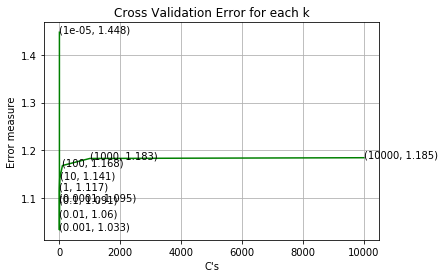

For values of C alpha =  0.001 The train log loss is: 0.6141766819611787
For values of C alpha =  0.001 The cross validation log loss is: 1.0333057729073143
For values of C alpha =  0.001 The test log loss is: 1.1724585537615217


In [106]:
alpha = [10 ** x for x in range(-5,5)]
cv_log_error = []
for i in alpha:
  clf=LogisticRegression(class_weight='balanced',C=i,penalty='l2',random_state=42,n_jobs=-1)
  clf.fit(train_text_feature_tfidf,y_train)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_text_feature_tfidf,y_train)
  predicted_y=sig_clf.predict_proba(cv_text_feature_tfidf)
  cv_log_error.append(log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))
  print("For the C value ",i,"the logg loss is :",log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))


fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each k")
plt.xlabel("C's")
plt.ylabel("Error measure")
plt.show()


best_alpha_text = np.argmin(cv_log_error)
clf = LogisticRegression(class_weight='balanced',C=alpha[best_alpha_text],penalty='l2',random_state=42,n_jobs=-1)
clf.fit(train_text_feature_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_tfidf, y_train)

predict_y_text = sig_clf.predict_proba(train_text_feature_tfidf)
print('For values of C alpha = ', alpha[best_alpha_text], "The train log loss is:",log_loss(y_train, predict_y_text, labels=clf.classes_, eps=1e-15))
predict_y1_text = sig_clf.predict_proba(cv_text_feature_tfidf)
print('For values of C alpha = ', alpha[best_alpha_text], "The cross validation log loss is:",log_loss(y_cv, predict_y1_text, labels=clf.classes_, eps=1e-15))
predict_y2_text = sig_clf.predict_proba(test_text_feature_tfidf)
print('For values of C alpha = ', alpha[best_alpha_text], "The test log loss is:",log_loss(y_test, predict_y2_text, labels=clf.classes_, eps=1e-15))

In [0]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [0]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [109]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_tfidf = hstack((train_gene_feature_tfidf,train_var_feature_tfidf))
cv_gene_var_tfidf = hstack((cv_gene_feature_tfidf,cv_var_feature_tfidf))
test_gene_var_tfidf = hstack((test_gene_feature_tfidf,test_var_feature_tfidf))
print("Shape of Gene feature in Train data is :",train_gene_feature_tfidf.shape[0])
print("Shape of Variation feature in Train data is :",train_var_feature_tfidf.shape[0])
print("Shape of Gene and Variation feature in Train data is :",train_gene_var_tfidf.shape[0])

train_x_tfidfCoding = hstack((train_gene_var_tfidf, train_text_feature_tfidf)).tocsr()
train_y = np.array(list(X_train['Class']))

test_x_tfidfCoding = hstack((test_gene_var_tfidf, test_text_feature_tfidf)).tocsr()
test_y = np.array(list(X_test['Class']))

cv_x_tfidfCoding = hstack((cv_gene_var_tfidf, cv_text_feature_tfidf)).tocsr()
cv_y = np.array(list(X_cv['Class']))

Shape of Gene feature in Train data is : 2124
Shape of Variation feature in Train data is : 2124
Shape of Gene and Variation feature in Train data is : 2124


In [110]:
print("Tfidf encoding features :")
print("(number of data points * number of features) in train data = ", train_x_tfidfCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_tfidfCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_tfidfCoding.shape)

Tfidf encoding features :
(number of data points * number of features) in train data =  (2124, 17186)
(number of data points * number of features) in test data =  (665, 17186)
(number of data points * number of features) in cross validation data = (532, 17186)


<h2> Logistic Regression Model :

For the C value  1e-05 the logg loss is : 1.447439989448782
For the C value  0.0001 the logg loss is : 1.0951564603846942
For the C value  0.001 the logg loss is : 1.0330445983052046
For the C value  0.01 the logg loss is : 1.060048016285468
For the C value  0.1 the logg loss is : 1.0895525673956687
For the C value  1 the logg loss is : 1.1085747027514898
For the C value  10 the logg loss is : 1.11183662234264
For the C value  100 the logg loss is : 1.1109460025435067
For the C value  1000 the logg loss is : 1.113539267275451
For the C value  10000 the logg loss is : 1.1149254868307177


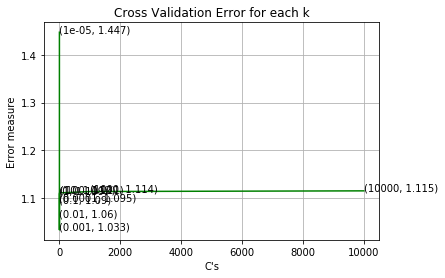

For values of C alpha =  0.001 The train log loss is: 0.6139259533736545
For values of C alpha =  0.001 The cross validation log loss is: 1.0330445983052046
For values of C alpha =  0.001 The test log loss is: 1.1722526253453058


In [111]:
alpha = [10 ** x for x in range(-5,5)]
cv_log_error = []
for i in alpha:
  clf=LogisticRegression(class_weight='balanced',C=i,penalty='l2',random_state=42,n_jobs=-1)
  clf.fit(train_x_tfidfCoding,y_train)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_x_tfidfCoding,y_train)
  predicted_y=sig_clf.predict_proba(cv_x_tfidfCoding)
  cv_log_error.append(log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))
  print("For the C value ",i,"the logg loss is :",log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))


fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each k")
plt.xlabel("C's")
plt.ylabel("Error measure")
plt.show()


best_alpha_model = np.argmin(cv_log_error)
clf = LogisticRegression(class_weight='balanced',C=alpha[best_alpha_model],penalty='l2',random_state=42,n_jobs=-1)
clf.fit(train_x_tfidfCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidfCoding, y_train)

predict_y_model = sig_clf.predict_proba(train_x_tfidfCoding)
print('For values of C alpha = ', alpha[best_alpha_model], "The train log loss is:",log_loss(y_train, predict_y_model, labels=clf.classes_, eps=1e-15))
predict_y1_model = sig_clf.predict_proba(cv_x_tfidfCoding)
print('For values of C alpha = ', alpha[best_alpha_model], "The cross validation log loss is:",log_loss(y_cv, predict_y1_model, labels=clf.classes_, eps=1e-15))
predict_y2_model = sig_clf.predict_proba(test_x_tfidfCoding)
print('For values of C alpha = ', alpha[best_alpha_model], "The test log loss is:",log_loss(y_test, predict_y2_model, labels=clf.classes_, eps=1e-15))

**Testing model with best hyper-parameter :**

Log loss : 1.1722526253453058
Number of mis-classified points : 0.4075187969924812
-------------------- Confusion matrix --------------------


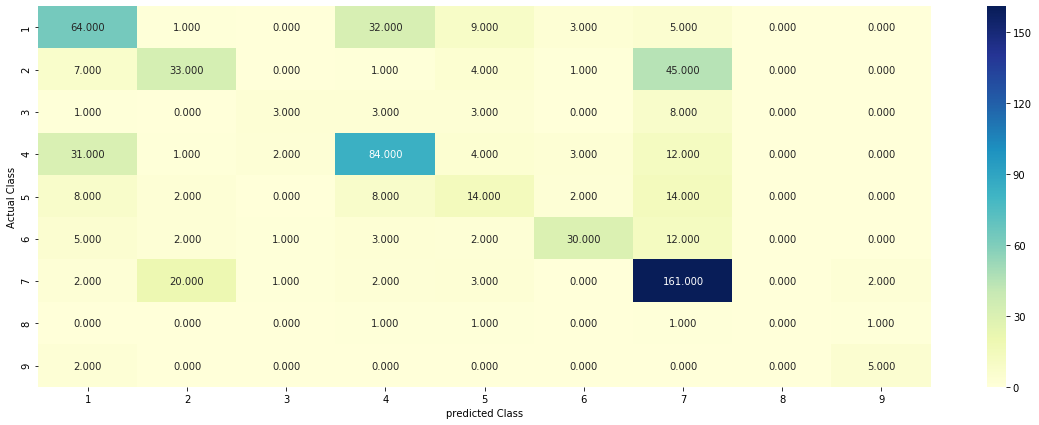

-------------------- Precision matrix (Column Sum = 1) --------------------


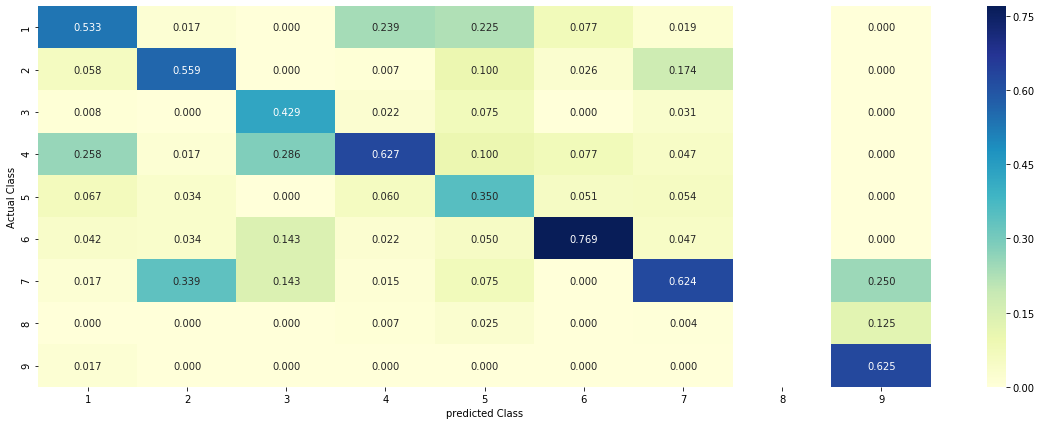

-------------------- Recall matrix (Row Sum = 1) --------------------


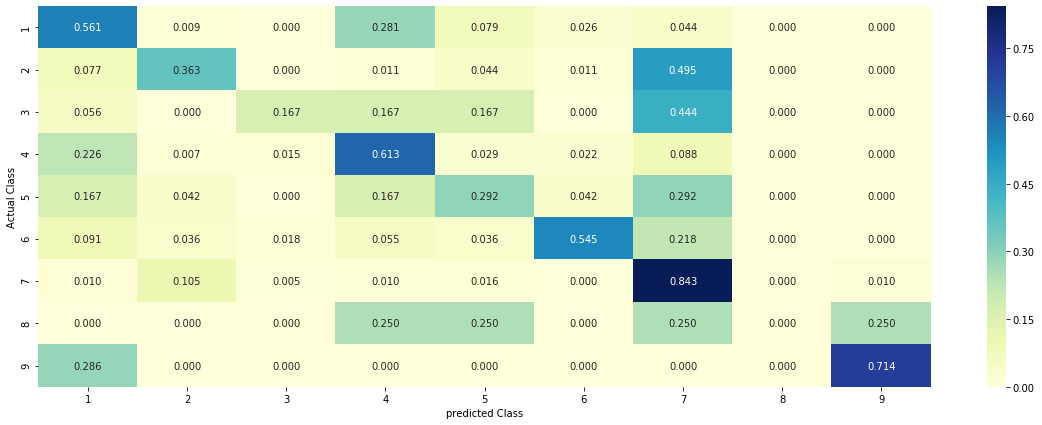

In [112]:
clf = LogisticRegression(C=alpha[best_alpha_model],class_weight='balanced',penalty='l2',random_state=42,n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_tfidfCoding, y_train, test_x_tfidfCoding, y_test, clf)

In [113]:
Weight_vector_before_eps = clf.coef_
print(Weight_vector_before_eps.shape)

(9, 17186)


<h3> Sample query point for correct class label: </h3>

In [114]:
test_point_index = 10
#no_feature = 100
predicted_cls = clf.predict(train_x_tfidfCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(train_x_tfidfCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[0.5873 0.0397 0.0034 0.2842 0.012  0.0086 0.0608 0.0022 0.0019]]
Actual Class : 1


<h3> Sample query point for incorrect class label : </h3>

In [115]:
test_point_index = 19
#no_feature = 100
predicted_cls = clf.predict(train_x_tfidfCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(train_x_tfidfCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])

Predicted Class : 4
Predicted Class Probabilities: [[0.1313 0.1107 0.0125 0.5173 0.0322 0.0384 0.1425 0.0075 0.0076]]
Actual Class : 3


Results :

In [116]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names =  ["Feature_Name","Best Hyperparameter","Train Log_Loss","CV Log_Loss","Test Log_Loss"]
x.add_row(["Gene", alpha[best_alpha_gene],log_loss(y_train, predict_y_gene, labels=clf.classes_, eps=1e-15), log_loss(y_cv, predict_y1_gene, labels=clf.classes_, eps=1e-15),log_loss(y_test, predict_y2_gene, labels=clf.classes_, eps=1e-15)])
x.add_row(["Variation", alpha[best_alpha_var],log_loss(y_train, predict_y_var, labels=clf.classes_, eps=1e-15),log_loss(y_cv, predict_y1_var, labels=clf.classes_, eps=1e-15),log_loss(y_test, predict_y2_var, labels=clf.classes_, eps=1e-15)])
x.add_row(["Text", alpha[best_alpha_text],log_loss(y_train, predict_y_text, labels=clf.classes_, eps=1e-15),log_loss(y_cv, predict_y1_text, labels=clf.classes_, eps=1e-15),log_loss(y_test, predict_y2_text, labels=clf.classes_, eps=1e-15)])
x.add_row(["Gene+Variation+Text", alpha[best_alpha_model],log_loss(y_train, predict_y_model, labels=clf.classes_, eps=1e-15),log_loss(y_cv, predict_y1_model, labels=clf.classes_, eps=1e-15),log_loss(y_test, predict_y2_model, labels=clf.classes_, eps=1e-15)])
print(x)

+---------------------+---------------------+--------------------+--------------------+--------------------+
|     Feature_Name    | Best Hyperparameter |   Train Log_Loss   |    CV Log_Loss     |   Test Log_Loss    |
+---------------------+---------------------+--------------------+--------------------+--------------------+
|         Gene        |          10         | 0.9895439996043248 | 1.168477223443221  | 1.2466627627285916 |
|      Variation      |          10         | 0.7894118109840166 | 1.6914554387414513 | 1.7180460938833293 |
|         Text        |        0.001        | 0.6141766819611787 | 1.0333057729073143 | 1.1724585537615217 |
| Gene+Variation+Text |        0.001        | 0.6139259533736545 | 1.0330445983052046 | 1.1722526253453058 |
+---------------------+---------------------+--------------------+--------------------+--------------------+


If you observe the log-loss for Geene and Varaiation and Text feature it's same as when we got for Text in Univariate analysis. However, we took only top 15000 samples based on idf score.

<h3>Perform Pertubation test to check if features are multicollinear :</h3>

In [117]:
import scipy as sp

#Weight vector before adding epsilon
W_before_epsilon = clf.coef_

#creating a epsilon value with the help of normal distribution
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)

#No of non zeros in train_x_tfidfCoding vector
no_of_non_zero = train_x_tfidfCoding.count_nonzero()

from scipy.sparse import csr_matrix

indices_X_train = train_x_tfidfCoding.indices
indptr_X_train = train_x_tfidfCoding.indptr

#Shape of train_x_tfidfCoding
Shape = train_x_tfidfCoding.shape

#creating data with the epsilon
data = [epsilon] * no_of_non_zero

#Creating Sparse matrix with epslion
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

#Adding the epsilon value to our train_x_tfidfCoding data 
epsilon_train = train_x_tfidfCoding + sparse_epsilon

#Shape of epsilpn matrix
print(train_x_tfidfCoding.shape)
print(epsilon_train.shape)

(2124, 17186)
(2124, 17186)


In [0]:
clf_aftr_eps = LogisticRegression(C=0.001,class_weight='balanced',penalty='l2',random_state=42,n_jobs=-1)
clf_aftr_eps.fit(epsilon_train,y_train)

#Weight vector after adding epsilon to train_x_tfidfCoding data
W_after_epsilon = clf_aftr_eps.coef_

In [125]:
#diff = (abs(weight1 - weight2)/weight1) * 100
percentage_of_change = abs( (W_before_epsilon-W_after_epsilon) / (W_before_epsilon) )*100
q = percentage_of_change[np.where(percentage_of_change > 30)].size
print("Percentage of features which did not change by more than 30% is :",(W_before_epsilon.size - q)/W_before_epsilon.size*100)

Percentage of features which did not change by more than 30% is : 99.98254393110672


From this we can conclude that the features are not multicollinear because almost more than 99% feature weight difference is not more than 30%. Hence they are not collinear in nature.